In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from torchvision import datasets, transforms, models
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import time
import seaborn as sns

In [18]:
trainSet = pd.read_csv('Dataset/train.csv')
classes = trainSet[['id','species']].copy()
classes['id'] = classes['id'].astype(str)
classes['label'] = LabelEncoder().fit_transform(classes['species'])

image_folder = 'Dataset/images/'
imgs = []
labels = []
for i in sorted(os.listdir(image_folder)):
    id = i.split('.')[0]
    if id in classes['id'].values:
        labels.append(classes[classes['id'] == id]['label'].values[0])
        image = Image.open(os.path.join(image_folder, i)).convert('1')
        imgs.append(image)

print(f"There are {len(imgs)} images in the dataset")
print(f"There are {len(np.unique(labels))} labels in the dataset")


There are 990 images in the dataset
There are 99 labels in the dataset


In [19]:

X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.2, random_state=42, stratify=labels)
print(f"There are {len(X_train)} images in the training set")
print(f"There are {len(X_test)} images in the test set")
print(f"There are {len(np.unique(y_train))} classes in the training set")
print(f"There are {len(np.unique(y_test))} classes in the test set")


There are 792 images in the training set
There are 198 images in the test set
There are 99 classes in the training set
There are 99 classes in the test set


In [20]:
class CustomDataSet(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.transform(image=np.array(self.images[index],dtype=np.float32))['image']
        label = torch.tensor(self.labels[index], dtype=torch.long)
        return image, label


    
transform = A.Compose([
    A.Resize(224, 224),
    ToTensorV2()
])

trainDataSet = CustomDataSet(images=X_train, labels=y_train, transform=transform)
testDataSet = CustomDataSet(images=X_test, labels=y_test, transform=transform)




In [21]:
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 99)

writer = SummaryWriter('runs/resnet18Architecture'+time.strftime("%Y%m%d-%H%M%S"))
writer.add_graph(model, torch.zeros([1,1,224,224]))
writer.close()

/Users/youssefgeorge/.pyenv/versions/3.9.18/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/youssefgeorge/.pyenv/versions/3.9.18/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
batch_size = 32
trainDataLoader = torch.utils.data.DataLoader(trainDataSet, batch_size=batch_size)
testDataLoader = torch.utils.data.DataLoader(testDataSet, batch_size=batch_size)

min_loss_epoch = 0
min_loss_value = -1
best_model_weights_paths = {}

best_val_loss = float('inf')  # Initialize with a large value
best_epoch = -1
best_model = None
train_losses = []
val_losses = []

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

writer = SummaryWriter('runs/resnet18/'+time.strftime("%Y%m%d-%H%M%S"))

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(trainDataLoader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(trainDataSet)
    train_losses.append(train_loss)
    
    # Validation loop
    model.eval()  
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for images, labels in testDataLoader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    accuracy = correct_predictions / total_samples
    val_loss = 1-accuracy
    val_losses.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_model = model
    
    writer.add_scalar('Training Loss', train_loss, epoch)
    writer.add_scalar('Validation Loss', val_loss, epoch)
    


Epoch 100/100: 100%|██████████| 25/25 [01:13<00:00,  2.96s/batch]


In [ ]:
best_epoch = val_losses.index(min(val_losses))
min_loss_epoch = best_epoch
min_loss_value = f'{min(val_losses):.4f}'
print(f"Min Train Loss: {min(train_losses)} at Epoch {train_losses.index(min(train_losses))}  Min Val Loss: {min_loss_value[criterion]} at Epoch {best_epoch}")


# Save the best model's weights
torch.save(model, f"best_model.pth")


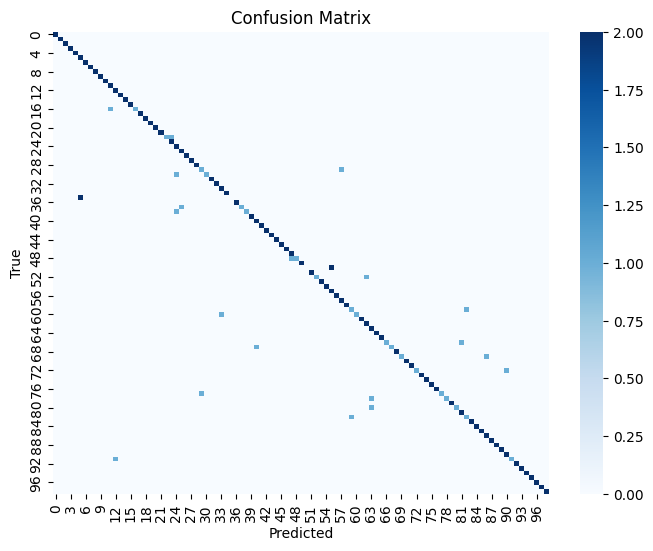

In [32]:
# print(f"Training accuracy = {round(accuracy_score(y_train_tensor, torch.max(best_model(X_train_tensor), 1)[1]),4)*100}%")
# print(f"Validation accuracy = {round(accuracy_score(y_test_tensor, predictions),3)*100}%")
# print(f"Best Validation Epoch = {best_epoch}")


best_model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in testDataLoader:
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        
        # Convert to numpy arrays
        predicted_np = predicted.cpu().numpy()
        labels_np = labels.cpu().numpy()

        # Append to the lists
        all_labels.extend(labels_np)
        all_predictions.extend(predicted_np)

# Create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
class_names = [str(i) for i in range(len(conf_matrix))]
sns.heatmap(conf_matrix, annot=False, fmt="g", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
